# 2: Topic Modelling with Latent Dirichlet Allocation

In [ ]:
'''This script is the second part in which an LDA model is built on the created data.'''
   
__author__ = 'Sandeep Kumar Kola'
__email__ = 'sandeep.kola07@gmail.com'

### General Introduction to Latent Dirichlet allocation:
* Latent Dirichlet allocation (LDA) comes under the branch of natural language processing in machine learning, and it is a generative statistical model.
* LDA is a classic example of topic model which works on the principle that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. 
* Accordingly, for example, if there are numerous documents in a folder, it posits that each document is a mixture of a several small number of topics and that each word's presence is attributable to one of the document's topics.

For more information regarding the theory behind the model, please refere to  https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

In [297]:
#Import the packages.
import re
import os
import spacy
import gensim
import pyLDAvis
import itertools
import numpy as np
import pandas as pd
import spacy.lang.en
import pyLDAvis.gensim
from pprint import pprint
from itertools import chain
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from spacy.lang.en import English
from bs4 import BeautifulSoup as bsoup
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Enable logging for gensim.
import logging
import warnings
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [298]:
class Data:
    """
    Class Data has functions which cleans up the data.
    """
    def __init__(self, path, stop_words_path, nlp_path):
        self.path = path
        self.stop_words_path = stop_words_path
        self.nlp_path = nlp_path
    
    def _clean_data(path):
    """
    _clean_data does some basic operations on the data files.

    Parameters:
    ----------
    path : Path where data files are present.

    Returns:
    -------
    data_dic : data for the model.
    label : label of the file in which the data is present.
    """
        index = 0
        data_dic = {}
        temp_list = []
        label = []
    
        for xfile in os.listdir(path):
            xfile = os.path.join(path, xfile)
            
            if os.path.isfile(xfile) and xfile.endswith('.txt'):
                with open(xfile, "r", encoding='utf8') as text_file:
                    uncleaned_data = text_file.read()
                    text_file.close()
                    
                    data_split = uncleaned_data.split()
                    for word in data_split:
                        if "**********" not in word:
                            temp_list.append(word)
                        else:
                            data_dic[index] = " ".join(temp_list) 
                            if len(xfile) == 23:
                                label.append(xfile[12:19])
                            else:
                                label.append(xfile[12:18])
                            temp_list = []
                            index = index + 1            
        return[data_dic, label] 
              
    def _create_dataframe(data):
    """
    _create_dataframe creates a pandas data frame, removes NA.

    Parameters:
    ----------
    data : Input data for the function.

    Returns:
    -------
    topic_data : data frame of the data.
    """
        topic_data = pd.DataFrame({'topic': list(data[0].values()),'label': data[1]})      
        topic_data['topic'].replace('', np.nan, inplace=True)
        topic_data.dropna(inplace=True)     
        return topic_data
    
    def _basic_process(sentence):
    """
    _basic_process uses gensim library, removes punctuation and does basic NLP operations.

    Parameters:
    ----------
    sentence : Input data.
    """
        for sent in sentence:
            yield(gensim.utils.simple_preprocess(str(sent), deacc=True))
    
    def _remove_stopwords(data):
    """
    _remove_stopwords removes stop words.

    Parameters:
    ----------
    data : Input data for the function.

    Returns:
    -------
    data_trimmed : trimmed output of input data.
    """
        stop_words = pd.read_csv(stop_words_path)
        stopwords_set = set(stop_words['a'])
        stopwords_set.add("mm")
        stopwords_set.add("_")
        stopwords_set.add("_")
        
        data_trimmed = []       
        for i in range(0, len(data)):
            temp = [w for w in data[i] if w not in stopwords_set]
            data_trimmed.append(temp)
        return data_trimmed
                   
    def _ngrams(data):
    """
    _ngrams creates bigrams and trigrams of the data.

    Parameters:
    ----------
    data : Input data for the function.

    Returns:
    -------
    data_ngrams : ngrammed output of input data.
    """
        bigram = gensim.models.Phrases(data, min_count=3, threshold=100)
        trigram = gensim.models.Phrases(bigram[data], threshold=100)  
        bigrams = gensim.models.phrases.Phraser(bigram)
        trigrams = gensim.models.phrases.Phraser(trigram)
        
        data_ngrams = []
        for i in range(0, len(data)):
            temp = trigrams[bigrams[data[i]]]
            data_ngrams.append(list(temp))
        return data_ngrams
    
    def _lemmatization(data):
    """
    _lemmatization does lemmatisation of the data: reducing the words to native noun form.

    Parameters:
    ----------
    data : Input data for the function.

    Returns:
    -------
    data_for_model : lemmatised output of input data.
    """
        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
        datas = []
        temp = []
        data_for_model = []
        for i in range(0, len(data)):
            doc = nlp_path(" ".join(data[i]))
            datas.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

        for data in datas:
            if data != []:
                for word in data:
                    if len(word) > 2:
                        temp.append(word)
                data_for_model.append(temp)
            temp = []
        return data_for_model

In [299]:
class BuildModel():
    """
    Class BuildModel has functions which builds the model on the data.
    """
    def __init__(self, mallet_path, data):
        self.data = data
        self.mallet_path = mallet_path

    def _cross_validation(wrapper, data_for_model, limit, start=2, step=3):
    """
    _cross_validation gets the best model from given parameters.

    Parameters:
    ----------
    wrapper: Type of wrapper to use.
    data_for_model: Input data of the function.
    limit: End of the num topics. 
    start=2: Start of the num topics.
    step=: Step size for num topics.

    Returns:
    -------
    model_list: List of all the models. 
    coherence_values: List of coherence values of all the models.
    """
        data_lemmatized = data_for_model
        id2word = corpora.Dictionary(data_lemmatized)
        texts = data_lemmatized
        corpus = [id2word.doc2bow(text) for text in texts]
        
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
            print("-- Doing model with No of Topics: " + str(num_topics) + " --")
            
            if wrapper == "lda":
                model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)  

            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())    
        return model_list, coherence_values
    
    def _plot_coherence(coherence_values, limit=10, start=5, step=3):
    """
    _cross_validation prodcues the plot of coherence values against num topics.
    Can be used to select the optimal no of topics.

    Parameters:
    ----------
    coherence_values: Coherence values of the models.
    limit: End of the num topics. 
    start=2: Start of the num topics.
    step=: Step size for num topics.
    """
        x = range(start, limit, step)
        plt.plot(x, coherence_values)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        plt.legend(("coherence_values"), loc='best')
        plt.show()

In [300]:
class SummarizeResults():
    """
    Class SummarizeResults has functions that help summarise and get the results on the data.
    """
    def __init__(self, data):
        self.data = data
    
    def _best_model(best):
    """
    _best_model gets the parameters of given best model.

    Parameters:
    ----------
    best: model to be used.

    Returns:
    -------
    perplexity: Perplexity of the optimal model.
    coherence: Coherence value of the optimal model.
    """
        print("\n -- Printing the best model -- \n")
        id2word = corpora.Dictionary(data_for_model)
        texts = data_for_model
        corpus = [id2word.doc2bow(text) for text in texts]
        optimal_model = model_list[best]
        model_topics = optimal_model.show_topics(formatted=False)
        pprint(optimal_model.print_topics(num_words=10))
        perplexity = optimal_model.log_perplexity(corpus)
        coherence = coherence_values[best]
        return perplexity, coherence
    
    def _format_topics(ldamodel, corpus, texts):
    """
    _format_topics gets dataframe of the corpus using the optimal model.

    Parameters:
    ----------
    ldamodel: optimal model.
    corpus: Corpus of the data.
    texts: Lemmatised version of the data.

    Returns:
    -------
    topics_df: dataframe of the topics.
    """
        topics_df = pd.DataFrame()
        for i, row in enumerate(ldamodel[corpus]):
            row_sorted = sorted(row[0], reverse=True)   
            for j, (topic_num, prop_topic) in enumerate(row_sorted):
                if j == 0: 
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                            topic_keywords]), ignore_index=True)
                else:
                    break
        topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        contents = pd.Series(texts)
        topics_df = pd.concat([topics_df, contents], axis=1)
        return(topics_df)

    def _dom_topic():
    """
    _dom_topic gets the dominant topic in each category.

    Returns:
    -------
    dominant_topic: dataframe of the dominant topics.
    """
        topic_keywords = _format_topics(optimal_model, corpus, texts)
        dominant_topic = topic_keywords.reset_index()
        dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        return dominant_topic
    
    def _most_rep_doc():
    """
    _most_rep_doc gets the most _most_rep_doc topic in each category.

    Returns:
    -------
    topics_sorted: sorted dataframe of the topics.
    """
        topics_sorted = pd.DataFrame()
        topics_grpd = topic_keywords.groupby('Dominant_Topic')

        for i, grp in topics_grpd:
            topics_sorted = pd.concat([topics_sorted, grp.sort_values(['Perc_Contribution'], 
                                                                      ascending=[0]).head(1)], axis=0)
        topics_sorted.reset_index(drop=True, inplace=True)
        topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
        return topics_sorted

    def _total_distribution():
    """
    _total_distribution gets the distribution of documents in each topic.

    Returns:
    -------
    dominant_topics: sorted dataframe of the distribution of documents in topics.
    """
        topic_counts = dominant_topic['Dominant_Topic'].value_counts()
        topic_distribution = pd.DataFrame({'Topic_Num':topic_counts.index, 'Num_Documents':topic_counts.values})
        topic_distribution["Perc_Documents"] = topic_distribution["Num_Documents"]/topic_counts.sum()
        topic_distribution.sort_values("Topic_Num", inplace=True)
        topic_distribution.reset_index(inplace=True)
        topic_distribution.drop(["index", "Topic_Num"], axis=1, inplace=True)
        dominant_topics = pd.concat([topic_num_keywords, topic_distribution], axis=1)
        return dominant_topics

    def _visualisation():
    """
    An interactive visualisation of words and topics: using pyLDAvis library.

    Returns:
    -------
    interactive_plot: ouputs an interactive plot.
    """
        pyLDAvis.enable_notebook()
        interactive_plot = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
        return interactive_plot

/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


-- Doing model with No of Topics: 5 --
-- Doing model with No of Topics: 10 --
-- Doing model with No of Topics: 15 --
-- Doing model with No of Topics: 20 --
-- Doing model with No of Topics: 25 --
-- Doing model with No of Topics: 30 --
-- Doing model with No of Topics: 35 --
-- Doing model with No of Topics: 40 --


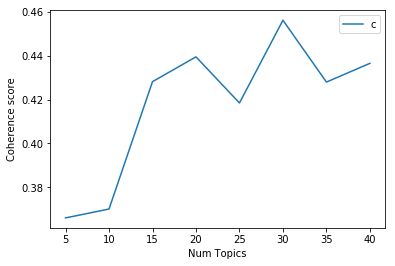

In [301]:
if __name__ == '__main__':
    # Local paths where files are presented.
    path = "./txt_files"
    stop_words_path = "stopwords_en.txt"
    nlp_path = spacy.load("/anaconda/lib/python3.6/site-packages/en_core_web_sm/en_core_web_sm-2.0.0")
    mallet_path = '/Users/sandeepkola/Documents/mallet-2.0.8/bin/mallet'
    # Clean the data.
    data = Data._clean_data(path)
    topic_data = Data._create_dataframe(data)
    data_words = list(Data._basic_process(list(topic_data['topic'])))
    data_trimmed = Data._remove_stopwords(data_words)
    data_ngrams = Data._ngrams(data_trimmed)
    data_for_model = Data._lemmatization(data_ngrams)
    # Build the model.
    model_list, coherence_values = BuildModel._cross_validation("lda", data_for_model, 41, 5, 5)  
    BuildModel._plot_coherence(coherence_values, 41, 5, 5)

In [302]:
# We see that the best model is: model with 30 topics
# Let's get the perplexity, coherence and visualise some results.
perplexity, coherence = SummarizeResults._best_model(5)
print('\n The perplexity of the optimal model is: ', perplexity)
print('\n The coherence of the optimal model is: ', coherence)


 -- Printing the best model -- 

[(15,
  '0.032*"mushroom" + 0.026*"white_board" + 0.025*"dead" + 0.018*"sixth_sense" '
  '+ 0.018*"scary" + 0.017*"usual_suspect" + 0.015*"nominate" + 0.015*"award" '
  '+ 0.013*"film" + 0.013*"violent"'),
 (2,
  '0.069*"charge" + 0.056*"cradle" + 0.051*"skip" + 0.036*"final" + '
  '0.027*"story" + 0.025*"disable" + 0.019*"corporate_identity" + 0.018*"food" '
  '+ 0.016*"prototype" + 0.016*"standby"'),
 (26,
  '0.100*"circuit_board" + 0.051*"home" + 0.045*"mode" + 0.043*"wire" + '
  '0.033*"sophisticated" + 0.018*"maximum" + 0.018*"proposal" + '
  '0.017*"priority" + 0.017*"recogniser" + 0.013*"transform"'),
 (7,
  '0.090*"powerpoint" + 0.030*"wee" + 0.026*"american_beauty" + 0.024*"haven" '
  '+ 0.021*"whiteboard" + 0.021*"character" + 0.020*"period" + 0.018*"ninety" '
  '+ 0.018*"nominate" + 0.015*"poster"'),
 (1,
  '0.063*"plan" + 0.045*"project" + 0.042*"discussion" + 0.032*"person" + '
  '0.023*"professor" + 0.020*"tool_train" + 0.015*"sebastian" 

In [303]:
# Let's look at the dominant topics in the corpus.
dominant_topic = SummarizeResults._dom_topic()
dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18,0.1747,"will, product, point, didn, bit, give, discuss...","[meet, busy, write, busy, lead, meeting, prepa..."
1,1,28,0.1763,"button, rubber, battery, case, push, plastic, ...","[component, design, accommodate, thing, elabor..."
2,2,19,0.0488,"design, user, work, interface, technical, prod...","[wrap, write, write, meet, thirty_minute, indi..."
3,3,27,0.0117,"button, colour, make, menu, screen, option, re...","[detailed, design, meeting, minute, prototype,..."
4,4,28,0.0675,"button, rubber, battery, case, push, plastic, ...","[make, prototype, aspect, meeting, look, form,..."
5,5,27,0.0699,"button, colour, make, menu, screen, option, re...","[detail, design, get, screen, leftmost, evalua..."
6,6,23,0.0441,"people, user, speech_recognition, technology, ...","[warning_finish, meeting, celebration, champag..."
7,7,28,0.0427,"button, rubber, battery, case, push, plastic, ...","[hmm, concept, design, meeting, start, summari..."
8,8,29,0.0121,"euro, sell, market, make, cost, product, price...","[presentation, conceptual, specification, indu..."
9,9,28,0.1790,"button, rubber, battery, case, push, plastic, ...","[shared_folder, presentation, time, move, slid..."


In [304]:
# Let's look at the most representative document of each class.
most_rep = SummarizeResults._most_rep_doc()
most_rep

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,12,0.0259,"thing, sort, kind, idea, will, wanna, guess, b...","[door, close, begin, time, meeting, will, hurr..."
1,14,0.0513,"work, time, put, room, information, true, didn...","[good, morning, put, plate, good, morning, goo..."
2,17,0.5050,"work, meeting, meet, thirty_minute, will, prot...","[move, meeting, lunch_break, individual, actio..."
3,18,0.2894,"will, product, point, didn, bit, give, discuss...","[good, morning, busy, job, good, morning, good..."
4,19,0.8028,"design, user, work, interface, technical, prod...","[hop, good, project, hear, function, project, ..."
5,20,0.1452,"movie, fairly, limit, combination, affect, tel...","[skip, goal, original, trendly, user, friendly..."
6,21,0.4516,"microphone, price, sell, marketing, camera, af...","[introduce, room, notice, black, field, table,..."
7,22,0.4991,"save, document, lunch, pen, rabbit, project, c...","[petre, call, petre, peter, care, bob, project..."
8,23,0.2532,"people, user, speech_recognition, technology, ...","[order, functional, requirement, find, people,..."
9,24,0.1268,"channel, button, volume, turn, interface, numb...","[guy, will, discuss, criterion, find, base, pa..."


In [305]:
# Let's look at the topic distribution.
total_distribution = SummarizeResults._total_distribution()
total_distribution

,Topic_Num,Keywords,Num_Documents,Perc_Documents
0,12,"thing, sort, kind, idea, will, wanna, guess, b...",1,0.001168
1,14,"work, time, put, room, information, true, didn...",1,0.001168
2,17,"work, meeting, meet, thirty_minute, will, prot...",1,0.001168
3,18,"will, product, point, didn, bit, give, discuss...",22,0.025701
4,19,"design, user, work, interface, technical, prod...",31,0.036215
5,20,"movie, fairly, limit, combination, affect, tel...",61,0.071262
6,21,"microphone, price, sell, marketing, camera, af...",14,0.016355
7,22,"save, document, lunch, pen, rabbit, project, c...",48,0.056075
8,23,"people, user, speech_recognition, technology, ...",37,0.043224
9,24,"channel, button, volume, turn, interface, numb...",26,0.030374


In [306]:
# Let's visualise the best model using pyLDAvis.
interactive_plot = SummarizeResults._visualisation()
interactive_plot

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      23.382026        1       1 -0.296300 -0.050409
12     12.571644        1       2 -0.254952  0.066904
3       7.330138        1       3 -0.193527 -0.009178
28      7.282407        1       4 -0.213575 -0.157410
27      6.792736        1       5 -0.239089 -0.175539
8       6.480115        1       6 -0.188829  0.231290
18      4.358524        1       7 -0.151218  0.185710
19      3.273969        1       8 -0.110593  0.112448
24      2.962837        1       9 -0.091764 -0.248095
20      2.688484        1      10  0.141483 -0.019538
14      2.452381        1      11 -0.104977  0.120152
23      2.029507        1      12 -0.011901  0.005517
9       1.848332        1      13 -0.043914 -0.144404
29      1.827926        1      14 -0.011953  0.052445
25      1.814218        1      15 -0.019431 -0.140193
11      1.803898        1      16  0.040688  0.101359
16      1.736764        1      17 -0.017601 -0.089151
17      1.362696        1      18  0.014603  0.192985
22      1.111528        1      19  0.037804  0.081661
21      1.031981        1      20  0.119754 -0.013429
10      1.027720        1      21  0.094796 -0.055870
1       0.742893        1      22  0.146059  0.043447
0       0.721855        1      23  0.138359  0.015398
6       0.648291        1      24  0.182990 -0.026267
13      0.604286        1      25  0.154438  0.002058
7       0.477298        1      26  0.185879 -0.014307
4       0.473653        1      27  0.135718  0.004348
26      0.429200        1      28  0.192310 -0.026883
15      0.423101        1      29  0.186589 -0.027189
2       0.309593        1      30  0.178152 -0.017858, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
43    Default  2171.000000              button  2171.000000  30.0000  30.0000
21    Default  2267.000000              remote  2267.000000  29.0000  29.0000
8     Default  1175.000000              design  1175.000000  28.0000  28.0000
6     Default  1890.000000             control  1890.000000  27.0000  27.0000
218   Default   654.000000             channel   654.000000  26.0000  26.0000
172   Default   645.000000                user   645.000000  25.0000  25.0000
194   Default   741.000000                work   741.000000  24.0000  24.0000
117   Default  1008.000000              people  1008.000000  23.0000  23.0000
193   Default  1163.000000                will  1163.000000  22.0000  22.0000
105   Default  1403.000000                make  1403.000000  21.0000  21.0000
85    Default   897.000000                good   897.000000  20.0000  20.0000
12    Default   493.000000             meeting   493.000000  19.0000  19.0000
50    Default   735.000000              colour   735.000000  18.0000  18.0000
945   Default   572.000000                sort   572.000000  17.0000  17.0000
488   Default   466.000000              market   466.000000  16.0000  16.0000
18    Default   414.000000        presentation   414.000000  15.0000  15.0000
24    Default   669.000000                time   669.000000  14.0000  14.0000
478   Default   270.000000                euro   270.000000  13.0000  13.0000
300   Default   500.000000             product   500.000000  12.0000  12.0000
33    Default   360.000000             battery   360.000000  11.0000  11.0000
251   Default   725.000000            function   725.000000  10.0000  10.0000
13    Default   350.000000              minute   350.000000   9.0000   9.0000
66    Default   241.000000                draw   241.000000   8.0000   8.0000
161   Default  1485.000000               thing  1485.000000   7.0000   7.0000
223   Default   386.000000                cost   386.000000   6.0000   6.0000
345   Default   315.000000              volume   315.000000   5.0000   5.0000
48    Default   247.000000                chi